# Results notebook

In [66]:
%reload_ext autoreload
%autoreload 2

from src.preprocessing import WikispeediaData
from src.similarity import *
from src.shortest_paths import *
from src.sum_graph import *
from src.hubs_analysis import *
from src.unfinished_games import *
from src.plot_functions import *

import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

# Wikispeedia : Hubs, User Patterns, and what can they say about Common Knowledge

In this notebook, we present the results for the analysis of our data story. The the data story is avalible: 

The goal of the analysis is to identify hubs and explore user navigation pattern. We analyse the role of hubs—highly connected articles—and user navigation patterns. By analyzing the characteristics and usage of hubs, common and abandoned paths, and more, we provide insights into how Wikipedia’s structure influences player strategies and efficiency. Our findings aim to learn something about common knowledge, user patterns, and the interplay between structure and strategy.

We begin with analysing the wikipedia version in the wikispeedia game- 

Then we analyse characteristics of hubs, give articles a continuous hub score based on page rank and their distribution across different categories.

Analysis of the Similarity Between Games: We examine the similarities in player behavior across different games to demonstrate that players follow comparable navigation patterns. This will helps us draw general conclusions about the structure of shared knowledge.

Analysis of Unfinished Games : We investigate unfinished game paths to spot where players face obstacles or fail to complete their games, showing potential gaps in public knowledge.

Analysis of Links : We analyze the distribution of links across categories and compare it to the links chosen by players during the game. This helps us understand how players navigate through the knowledge graph.

Analysis of Shortest Paths : We compute the shortest paths for each completed game and analyze the articles most presdent in shortest paths, identifying efficient hubs in the knowledge graph.

Through this detailed analysis, we aim to gain valuable insights from the data, which will guide the further exploration and data analysis throughout the project.

In [4]:
#Creating data object, dictionary of dataframes
data = WikispeediaData()

In [39]:
#Setting theme for plots
sns.set_theme() 

## Wikispedia in the Wikispeedia game

We begin with exploring the version of Wikipedia in the Wikispeedia game.

In [46]:
print('Number of articles in Wikispeedia version of Wikipedia', len(data.articles))

Number of articles in Wikispeedia version of Wikipedia 4604


In [47]:
print('Maximum shortest path between one article to another:', max(map(np.nanmax, data.matrix)))

Maximum shortest path between one article to another: 9.0


From this data we can see that the version of Wikipedia in Wikispeedia containts 4604 articles and if it is possible to navigate from one article to another the target article is maximum 9 clicks away. That means from one article to any other which it is possible to navigate to 9 is the maximum number of clicks you might have to do to reach the target article. Now let's analyse the distribution of categories! 

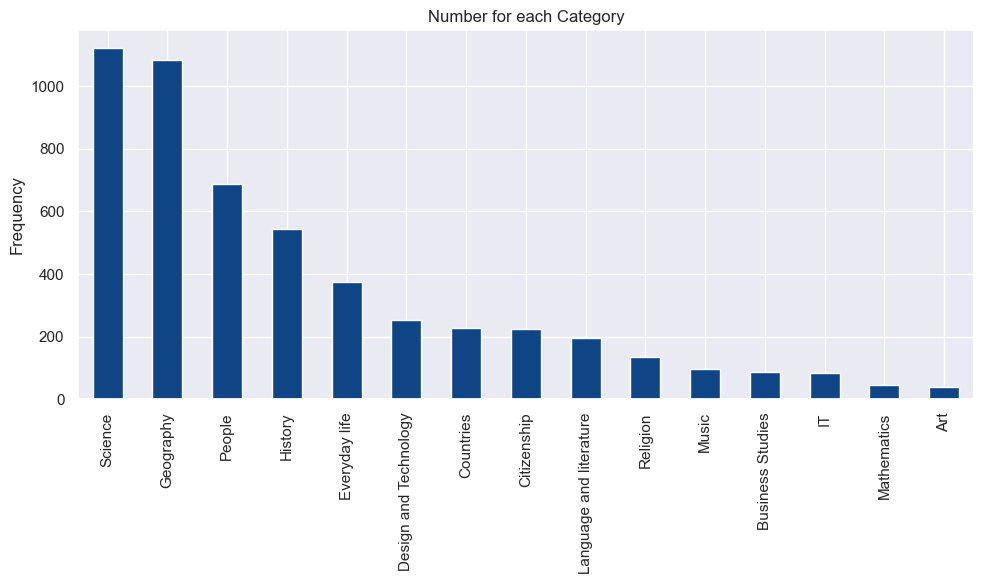

In [48]:
fig, ax = plt.subplots(1, figsize=(10, 6))
data.categories['1st cat'].value_counts().plot(kind='bar', ax=ax, color="#0f4584", title="Number for each Category")
ax.set_xlabel("")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

The figure above shows the distributions of categories on Wikipedia. Note that each article is categoriesed as belonging to one or more topics. The category of an article is not neccesarily unique as one article can belong to several topics for example Wood which belongs to both the Science and Design and Technology, see results below. We can see that the most common categories of articles are Science and Geography.

In [49]:
print('Categories for article Wood:')
print(data.categories['1st cat'].loc[data.categories['article_name']=='Wood'].values)

Categories for article Wood:
['Design and Technology' 'Science']


## Analysis of characteristics of hubs
For this part we do an initial analysis of the articles on wikipedia to try and get a better understanding of them and which articles are potentially hubs, by looking at the characteristics of a hubs. A hub is a link that is well connected in the Wikipedia network and can be used to navigate to many other articles. The characteristics used are number of links from the article (source count), number of links to the article (target count), the mean shortest path from the article to other articles and finally the mean shortest path to the article from other articles. 

The characteristics of the hubs is loaded into a dataframe and it also contains the category of each hub, since one article can belong to one or more articles each category has one column and the article has a value of 1 for that column if it belongs to that category.

In [50]:
#Getting dataframe with data of hub characteristics 
# For all articles: target count, source count, mean shortest path to/from the article to any article in the network and their category(ies)
df_hubs = get_hubs_dataframe(data)

In [51]:
df_hubs.head()

,article_names,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path,Art,Business Studies,Citizenship,Countries,Design and Technology,Everyday life,Geography,History,IT,Language and literature,Mathematics,Music,People,Religion,Science
0,Áedán mac Gabráin,11,0,0.0,3.395464,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Åland,19,0,0.0,3.127959,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,Édouard Manet,20,0,0.0,3.171598,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Éire,8,0,0.0,3.325937,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,Óengus I of the Picts,10,0,0.0,3.386834,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [52]:
#Printing statistics for dataframe
df_hubs[['source_counts', 'target_counts','mean_shortest_path_to_article','mean_shortest_path']].describe()

,source_counts,target_counts,mean_shortest_path_to_article,mean_shortest_path
count,4604.000000,4604.000000,4604.000000,4604.000000
mean,26.038662,26.038662,2.829412,3.188769
std,24.201491,62.746827,1.170888,0.321702
min,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,2.626172,3.025154
50%,19.000000,8.000000,2.989640,3.179408
75%,33.000000,25.000000,3.476390,3.344081
max,294.000000,1551.000000,6.866085,5.119852


From the statistics above we see that wikipidia pages have on average the same amount of articles to and from them, however the median is lower than the mean in both cases indicating a skewed distribution of the number of articles to and from wikipedia pages. Lets look closer at the distributions of these.

**Distribution of source and target count for all articles**

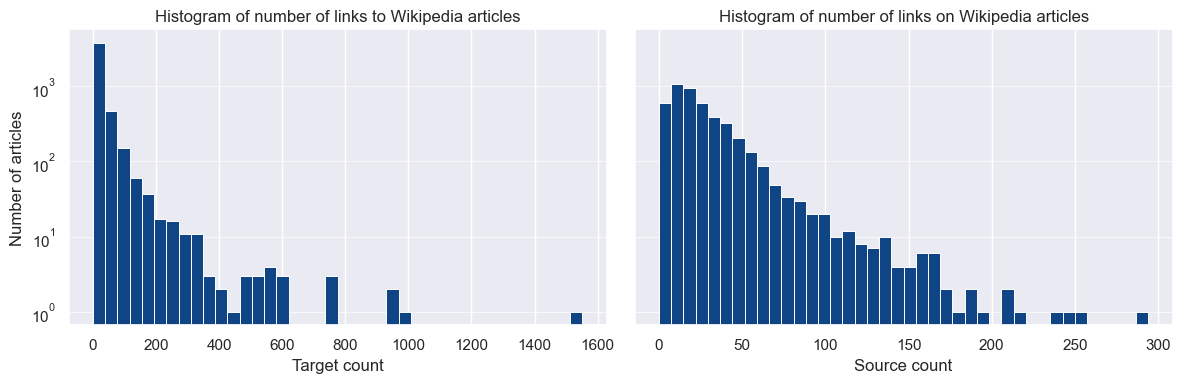

In [68]:
plot_two_distributions(df_hubs, "target_counts", "source_counts", 'Histogram of number of links to Wikipedia articles', 
                       'Histogram of number of links on Wikipedia articles','Target count','Number of articles','Source count', 
                       'Number of articles',log_scale = True)

Note that the y-axis of the plot is in log scale. From the distribution of links we can clearly see that there is a variation in the number of links on wikipedia pages and that there are many articles with fewer links to them and some articles have many links to them. 

**Distribution of mean shortest path to and from articles for all articles**

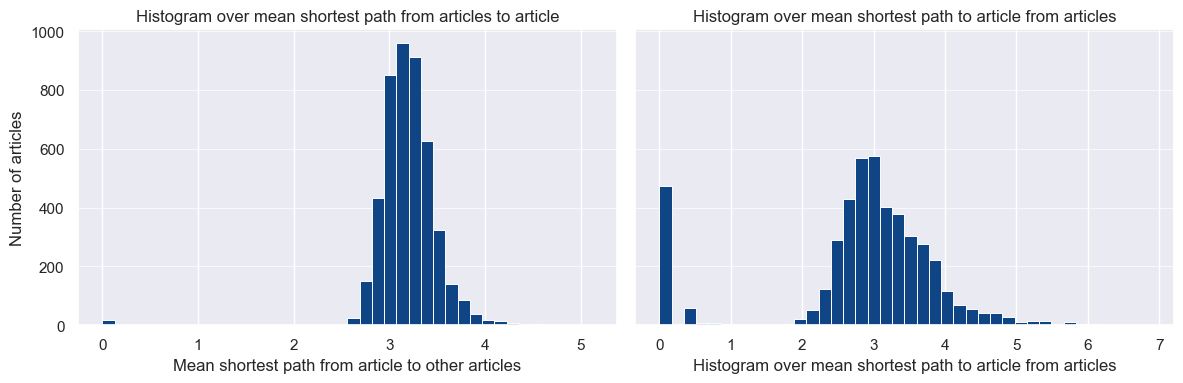

In [70]:
plot_two_distributions(df_hubs, "mean_shortest_path", "mean_shortest_path_to_article", 'Histogram over mean shortest path from articles to article', 
                       'Histogram over mean shortest path to article from articles','Mean shortest path from article to other articles',
                       'Number of articles','Histogram over mean shortest path to article from articles', 'Number of articles')

In the first plot we see that the distribution of mean shortest path to another article is much more evenly distributed. We can see that there are some articles which have a very short mean shortest path. However, this does not mean that they are more connected to other articles in the network since nan mean was used to calculate the mean shortest path. Therefore articles which are not connected to any other article will have a value of 0.

**Looking at extreme values in distributions**

Here we are looking at the extreme values to get an understanding of what articles might be hubs. We are looking at the articles which have the most links to and from them. We are also looking at the ones which have a short mean path to any other article. 

In [60]:
top_10_source = df_hubs.nlargest(10, 'source_counts')[['article_names', 'source_counts']]
print('Articles with most of links from them:')
print(top_10_source)

Articles with most of links from them:
                                  article_names  source_counts
4297                              United States            294
1247               Driving on the left or right            255
2504                          List of countries            244
2503             List of circulating currencies            236
2515                   List of sovereign states            216
128                                      Africa            212
2505  List of countries by system of government            207
2433                                    Lebanon            192
2134                                   Interpol            191
340                                     Armenia            186


In [61]:
top_10_target = df_hubs.nlargest(10, 'target_counts')[['article_names', 'target_counts']]
print('Articles with most of links to them:')
print(top_10_target)

Articles with most of links to them:
         article_names  target_counts
4297     United States           1551
4293    United Kingdom            972
1568            France            959
1433            Europe            933
1385           England            751
4542      World War II            751
1694           Germany            743
2098             India            611
1389  English language            598
2538            London            587


When calculating the mean shortest path nan mean was used meaning that if an article is not connected to any other article or very few articles the mean shortest path will be very low. Therefore these cases are analysed further and will not be considered as having a short path.

In [62]:
min_indices = df_hubs[df_hubs["mean_shortest_path"] < 1].index

print('Number of articles with min distance')
article_names_at_min_indices = df_hubs["article_names"].iloc[min_indices]
print(len(article_names_at_min_indices))

Number of articles with min distance
19


In [64]:
df_hubs_filtered = df_hubs.drop(min_indices)

top_10_shortest_path = df_hubs_filtered.nsmallest(10, 'mean_shortest_path')[['article_names', 'mean_shortest_path']]

print('Articles with mean shortest path to other articles:')
print(top_10_shortest_path)

Articles with mean shortest path to other articles:
                     article_names  mean_shortest_path
4297                 United States            2.484834
39                    21st century            2.563502
1989          History of the world            2.578792
331                      Argentina            2.586436
24                    19th century            2.596054
4293                United Kingdom            2.606165
1247  Driving on the left or right            2.609467
128                         Africa            2.622935
3966                      Swastika            2.626387
1694                       Germany            2.626880


#### How many articles are in all top 10?

In [65]:
article_names_source = set(top_10_source['article_names'])
article_names_shortest_path = set(top_10_shortest_path['article_names'])
article_names_target = set(top_10_target['article_names'])

common_articles_set = article_names_source & article_names_shortest_path & article_names_target

# Print the common article names
print("Articles present in all three:")
print(common_articles_set)

Articles present in all three:
{'United States'}


We see that only one article is in the top 10 of all the used characteristics of a hub. In order to create a continuous metric for the interconnectedness of an article or the hubness of an article PageRank was used.

### PageRank
The PageRank algorithm gives a continuous measure from 0 to 1 of how important an article is in the network by looking at the number of links to that article and the quality of the link. The "quality" of the link refers to how many incoming edges that node (article) has. Therefore, PageRank is an iterative algorithm to rank nodes in a graph network.

However, the traditional PageRank algorithm highly prioritizes incoming edges to a node, with little consideration given to number of outgoing edges. For our purposes, we need to consider both target and source count, to understand articles that are truly cornerstones within the Wikispeedia game. We therefore adjusted the PageRank algorithm to give equal weighting to nodes with a high number of incoming edges and nodes with a higher number of outoing edges.

In [72]:
# call PageRank functions
df_hubs = calculate_pagerank(data, df_hubs)
df_hubs = calculate_outgoing_pagerank(data, df_hubs)
df_hubs, df_filtered_hubs = create_hub_score(df_hubs)

PageRank values represent the probability that a random internet surfer will land on that node/page. So the sum of the pagerank value for all the nodes is 1. As expected, the top values are United States, France, and Europe. 

### Looking at correlation between features
Looking at the correlation between features after removing articles which are disconnected from the larger network.

In [14]:
cols = ['source_counts','target_counts','mean_shortest_path_to_article','mean_shortest_path']

p_values , correlation_matrix = calculate_correlation(df_hubs_filtered, cols)

print("p-values for correlation")
print(p_values)

p-values for correlation
[[0.00000000e+000 0.00000000e+000 4.33493109e-006 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.23469942e-011 7.03349085e-126]
 [4.33493109e-006 1.23469942e-011 0.00000000e+000 2.76308555e-001]
 [0.00000000e+000 7.03349085e-126 2.76308555e-001 0.00000000e+000]]


All correlations are significant with a significance threshold of 0.01 except for mean shortest path from article and mean shortest path to article, which is non-significant.


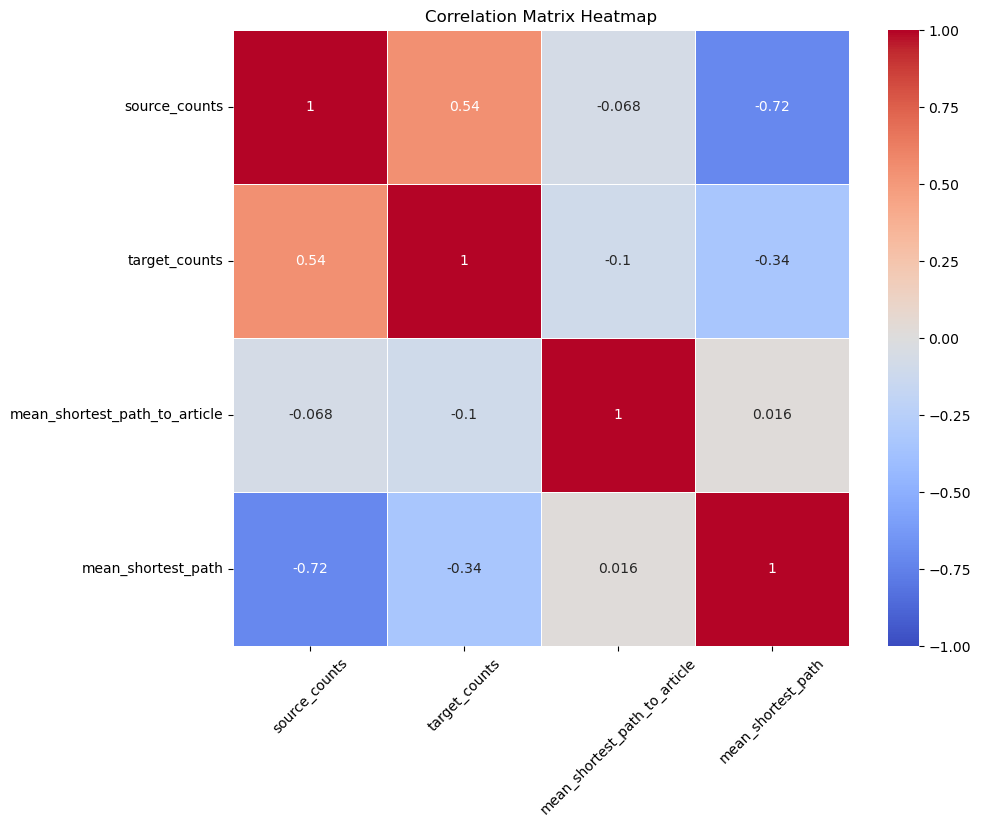

In [15]:
#Plotting correlation matrix
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5,
            xticklabels=cols, yticklabels=cols)

plt.xticks(rotation=45)
plt.title('Correlation Matrix Heatmap')
plt.show()

From the correlation matrix we can see that articles with more links on them generally have more links to them or vice versa. Articles with more links to them and from them are negatively correlated with the number of links on them and the number of links to them. 

### Looking at articles by category
Now deepening the analysis and looking at the categories of the articles. First looking at the distribution of articles by category.

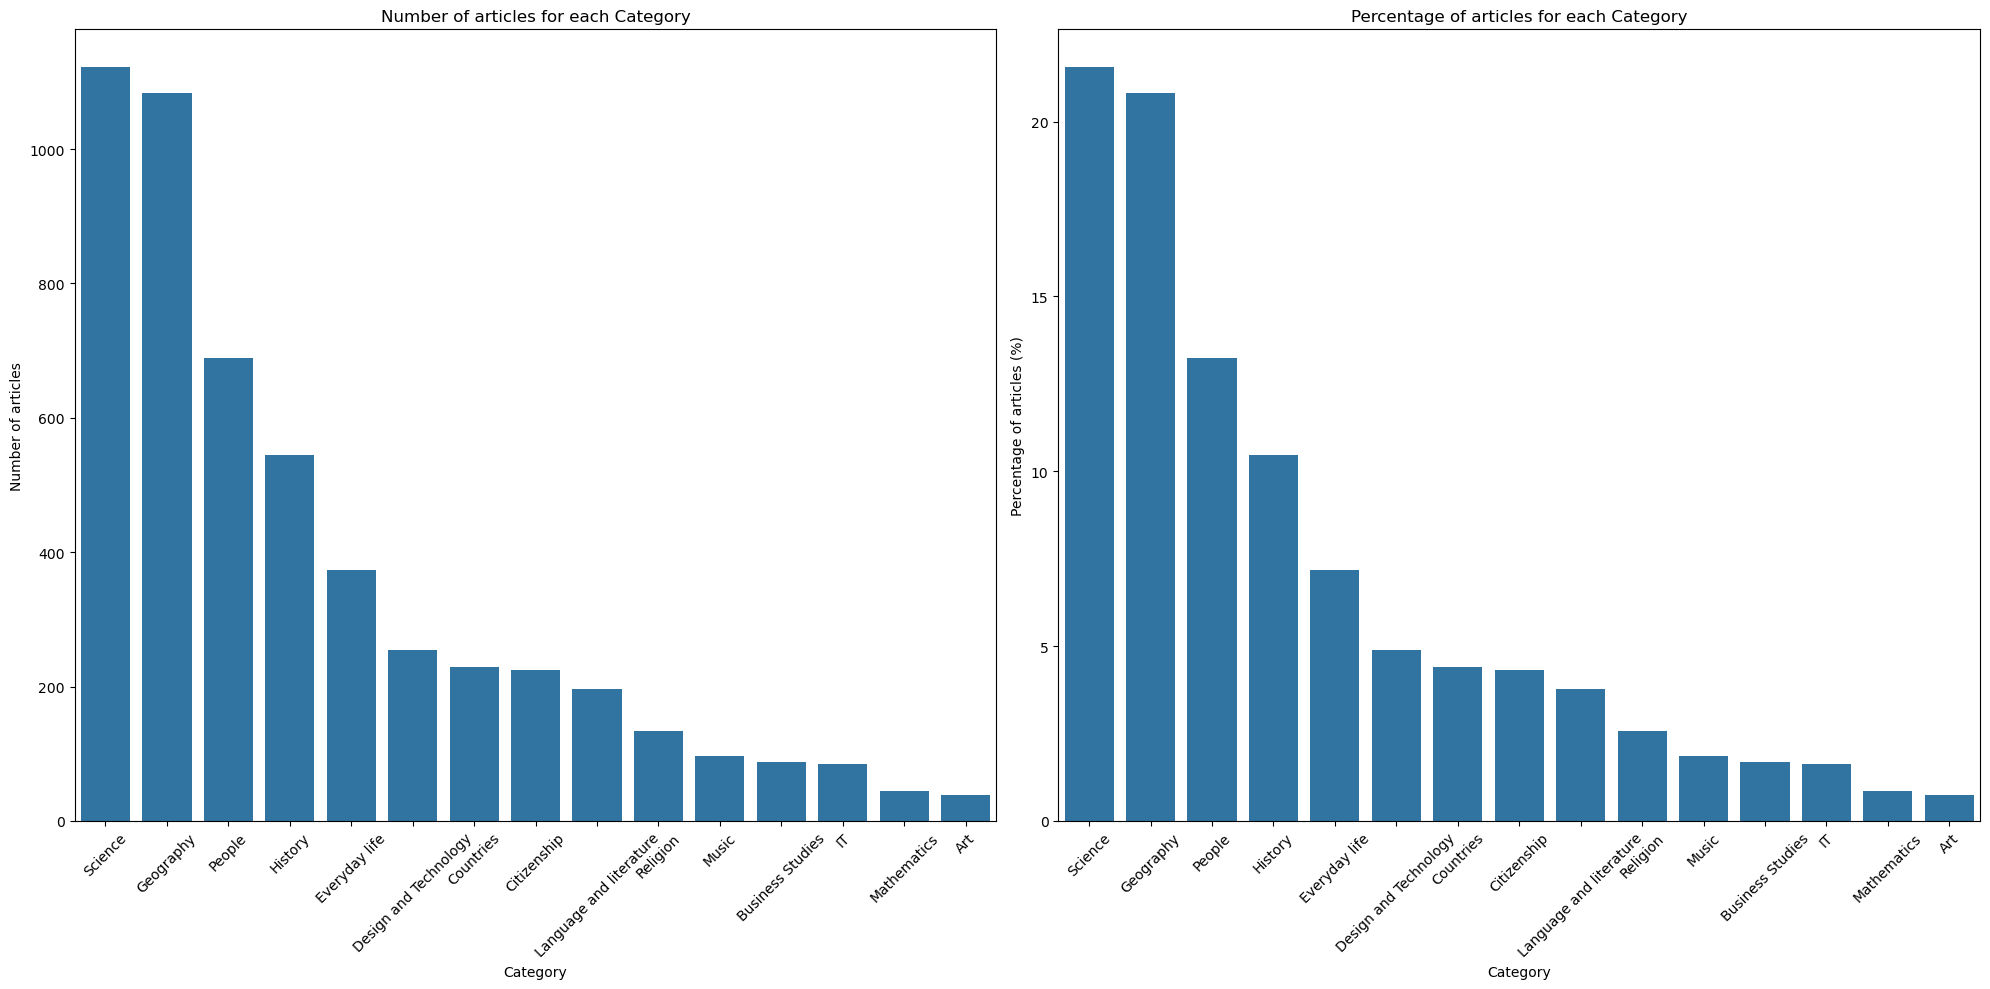

In [16]:
# Calculating counts and converting to percentages
category_counts = data.categories['1st cat'].value_counts()
category_percentages = (category_counts / category_counts.sum()) * 100

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plotting counts
sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[0])
axes[0].set_title("Number of articles for each Category")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Number of articles")
axes[0].tick_params(axis='x', rotation=45)

# Plotting percentages
sns.barplot(x=category_percentages.index, y=category_percentages.values, ax=axes[1])
axes[1].set_title("Percentage of articles for each Category")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Percentage of articles (%)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

We can see that more than half of the articles are related to Science and Geography. The distribution of articles by category differs greatly. Not very unexpected but interesting. What about the links to and from articles of specific categories? Does the mean value differ greatly as well?

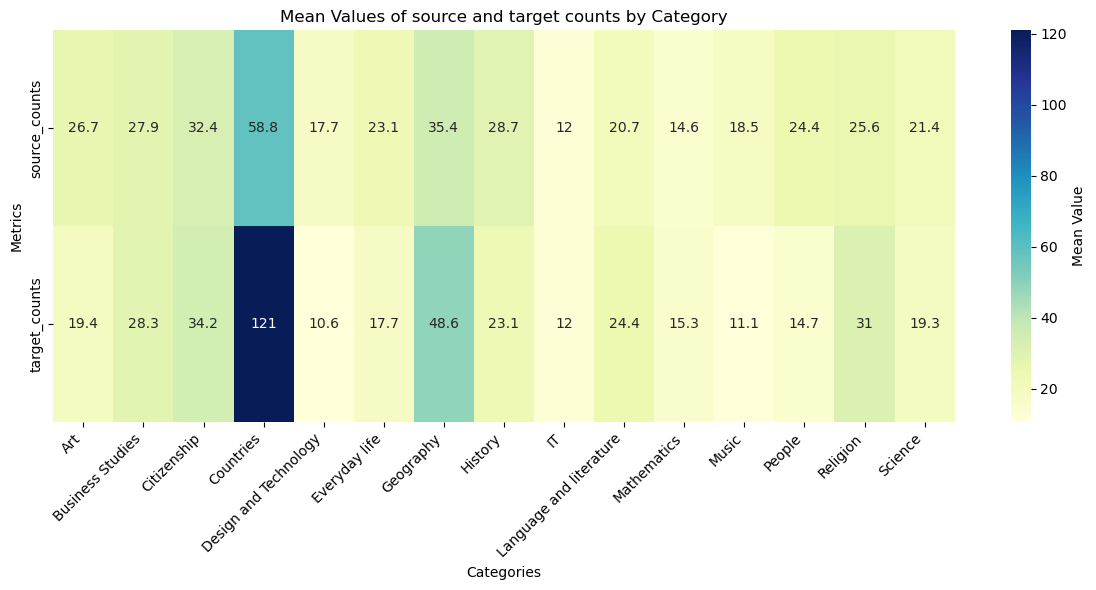

In [17]:
categories = df_hubs.columns[5:]

# Create matrix for plotting
matrix = pd.DataFrame({
    "source_counts": df_hubs[categories].multiply(df_hubs["source_counts"], axis=0).sum() / df_hubs[categories].sum(),
    "target_counts": df_hubs[categories].multiply(df_hubs["target_counts"], axis=0).sum() / df_hubs[categories].sum()}).T

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Value'}, fmt='.3g')
plt.title('Mean Values of source and target counts by Category')
plt.xlabel('Categories')
plt.ylabel('Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From this plot we can see that indeed it does for the number of links on pages Geography pages has the most with a mean value of 58.8 links per article. Geography comes in second with 35.4 and interestingly science is not in the top.

For the number of links to pages countries and Geograpy are in the top. Very interesting results, to be analysed more. How much does a single article contribute to this number? Create a similar plot but for median values is also something that will be explored.

## Analysis of the similarity between games

To identify a "common knowledge" shared among the players of the game, we must demonstrate that players exhibit similar behavior during their games. To achieve this, we need to examine how different players approach the same game (with the same starting point and target) and assess the degree of similarity in the path they take to navigate. To do so we will look at the finished paths of the players and compare them to each other for same games.

In [18]:
games = get_games(data)
print("Number of games: ", len(games))
print("Number of games with more than 10 participants: ", games[games["nb_games"] > 10].shape[0])
games.sort_values("nb_games", ascending=False).head(10)

100%|██████████| 51318/51318 [04:48<00:00, 177.60it/s]

Number of games:  28718
Number of games with more than 10 participants:  126


,start,end,nb_games
5526,Asteroid,Viking,1043
6158,Brain,Telephone,1040
27239,Theatre,Zebra,905
9219,Pyramid,Bean,642
466,Batman,Wood,148
537,Bird,Great white shark,138
464,Batman,The Holocaust,119
536,Bird,Adolf Hitler,107
507,Beer,Sun,99
484,Batman,Banana,69


We can see that among the finished paths of the players, there are many games but only a few of them have more than 10 players. To gain a clearer understanding of the similarity between players, we will focus on these games with larger player participation.

A first idea is to create a **distance between two paths** in the wiki-graph. If two players, playing the same game, have similar paths (i.e., a short distance between their paths), we can assume that they behave similarly. Conversely, if the paths are different (i.e., a long distance between them), we can infer that the players' behaviors differ.

There are various ways to measure the similarity between two paths, we decided to implement two distances that give different insights on the data :
- **Jacard distance** : the number of common nodes divided by the number of nodes in the union of the two paths
- **Shortest Path-based Distance (SP)**: $$d(p_1,p_2)= \max_i (\min_j SP(p_1[i],p_2[j]))$$ where $p_1$ and $p_2$ are the two paths to compare and $SP(p_1[i],p_2[j])$ is the length of the shortest path from $p_1[i]$ to $p_2[j]$. Note that this distance is not symmetric, but we can make it symmetric by taking the maximum distance of the two directions. This distance can be interpreted as the maximum number of clicks separating the two paths at any point during the navigation.

We can analyse the similarity between paths taken by players for each game with more than 10 players we have. Here we present the results for one game starting from "Calculus" and ending at "Paul McCartney".

Game from  Calculus  to  Paul McCartney


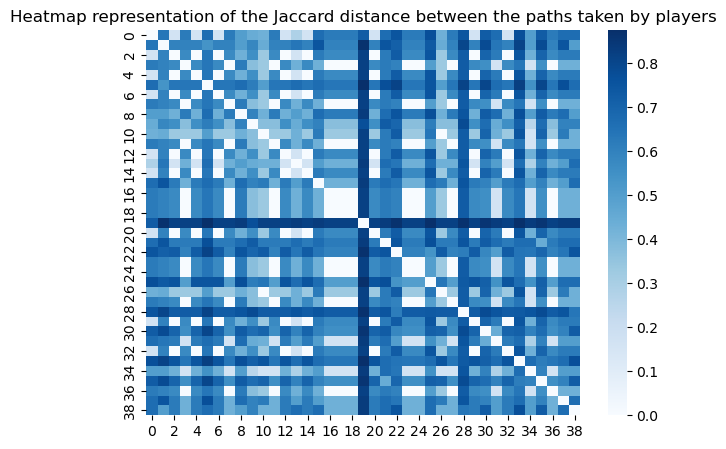

Mean distance for game from  Calculus  to  Paul McCartney  :  0.5025753980070026
Game from  Calculus  to  Paul McCartney


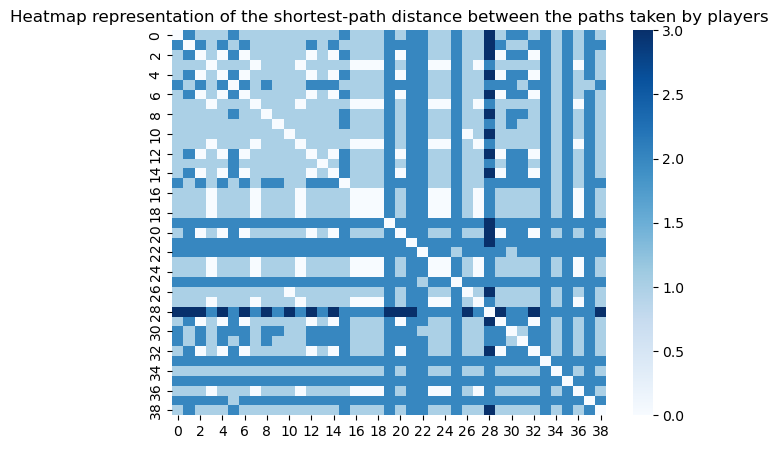

Mean distance for game from  Calculus  to  Paul McCartney  :  1.3372781065088757


In [19]:
start = "Calculus"
end = "Paul McCartney"

plot_sim_matrices(data,[start],[end],distance = distance_Jaccard, title = "Heatmap representation of the Jaccard distance between the paths taken by players")
plot_sim_matrices(data,[start],[end],distance = distance_matrix, title = "Heatmap representation of the shortest-path distance between the paths taken by players")

For the game "Calculus" to "Paul McCartney", the results can be interpreted as follows :
- The average Jacard distance between two paths is 0.5. This means that on average,  two players share 50% of the articles they pass through.
- The average shortest path distance is 1.3. This means that on average, two players are at most 1.3 clicks away from each other during this game. 

These results give us a good indication of how similarly the players behave. From this, we can infer that they tend to take similar paths, likely due to shared knowledge or common strategies.

Another approach is to analyze the **similarity between the first clicked articles of two players**. For this analysis, we focus on a game with more than 10 players, specifically examining the similarity between the first articles each player visits. While we will continue analyzing the game from "Calculus" to "Paul McCartney" in this case, this approach can be applied to any game with a sufficient number of players.

This analysis can provide valuable insight into whether players' initial approach to the game and their understanding of the target article are similar or not.

To measure this similarity, we compute the mean distance between the first articles clicked by two players, using the shortest path distance.



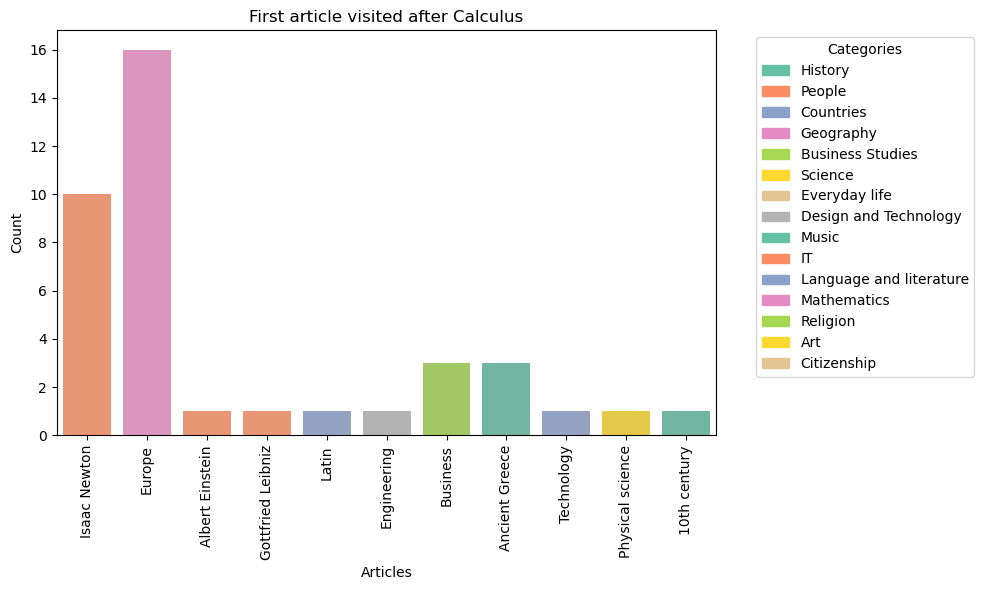

The mean distance between two first articles visited after Calculus by different players is:  1.1443994601889338


In [20]:
start = "Calculus"
end = "Paul McCartney"
plot_first_article_bar_chart(data,start, end)
print("The mean distance between two first articles visited after Calculus by different players is: ", distance_first_article(data, start, end))

These results can be interpreted as follows:

- The vast majority of players tend to click on either "Europe" or "Isaac Newton" as their first article, indicating that most players behave similarly.

- There is also a noticeable similarity in the categories of the first articles clicked by players. For example, most players start by clicking on articles related to "People" or "Geography."

- The average distance between the first articles clicked by two players is 1.5, suggesting that the first clicked articles are often quite close to each other. For instance, "Isaac Newton," "Physical Science," and "Albert Einstein" are examples of closely related first articles.


We can then compute this average distance for all games with more than 10 players (and fewer than 100 players to manage computational complexity) and analyze the results.

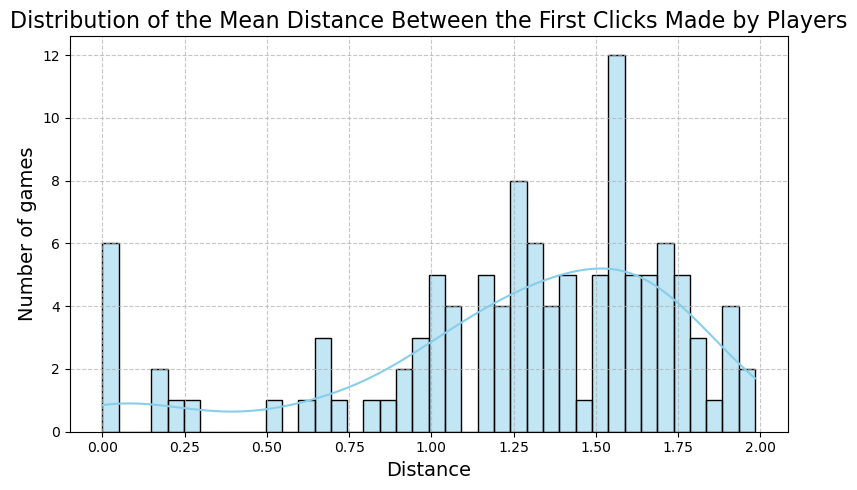

In [21]:
games_valid = games[(games["nb_games"] > 10)& (games["nb_games"] < 100)].copy()
games_valid["dist_first_article"] = games_valid.apply(
    lambda x: distance_first_article(data, x["start"], x["end"]), axis=1
)
plt.figure(figsize=(8, 5))
sns.histplot(games_valid["dist_first_article"], bins=40, kde=True, color="skyblue")

plt.title("Distribution of the Mean Distance Between the First Clicks Made by Players", fontsize=16)
plt.xlabel("Distance", fontsize=14)
plt.ylabel("Number of games", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

We see that on average for all games , the average distance between the first articles clicked by two players is  around 1.5. This indicates that players tend to start their games with similar articles, likely due to shared knowledge or common strategies.

## Analysis of unfinished games

To understand and analyze the common knowledge shared by players, it is important to have a look at the unfinished games. These games offer valuable insights into players' behaviors, particularly in identifying areas where they tend to lack knowledge.

We can first have a look at the most common unfinished games :

In [22]:
games_unfinished = get_games_unfinished(data)
games_unfinished.sort_values("nb_games",ascending =False).head()

  0%|          | 0/24875 [00:00<?, ?it/s]

100%|██████████| 24875/24875 [01:28<00:00, 282.20it/s]


,start,target,nb_games
1578,Brain,Telephone,1004
1580,Pyramid,Bean,944
1577,Theatre,Zebra,872
1594,Asteroid,Viking,727
6772,Batman,Wood,75


We can identify some of these games that also appear among the most frequently completed games. For example, the game "Brain to Telephone" was finished 1,040 times and abandoned 1,004 times. This presents an interesting opportunity to calculate a success rate for each game, which can provide a better measure of the difficulty of a game.

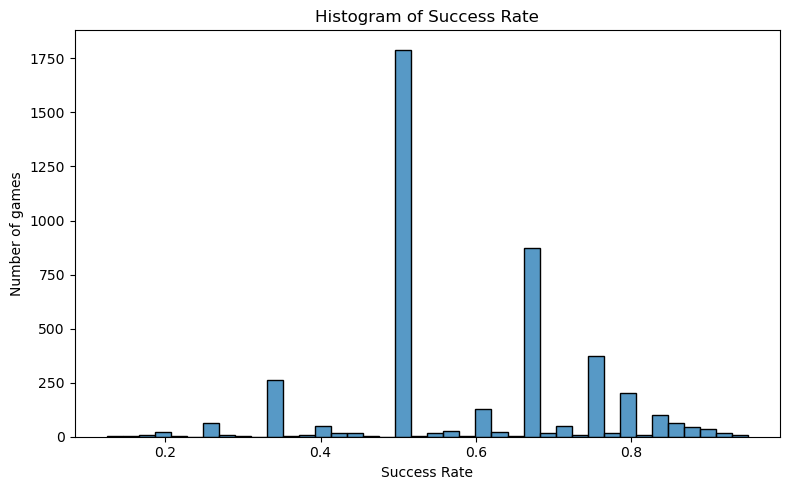

In [23]:
games_unfinished = success_rate(games_unfinished,games)
games_unfinished_filtered = games_unfinished[games_unfinished["success_rate"].notna()]
plt.figure(figsize=(8, 5))
sns.histplot(games_unfinished_filtered["success_rate"], bins=40)

plt.title("Histogram of Success Rate")
plt.xlabel("Success Rate")
plt.ylabel("Number of games")

plt.tight_layout()
plt.show()

We observe that most games have a success rate around 0.5. However, we can see that some games have very high (resp very low) success rates, and it would be interesting to analyze them as they may reveal patterns of common knowledge (or lack ) among players.

Additionally, we want to investigate where the games tend to stop, as this can provide valuable insights into why players abandon the game. Did they encounter a dead-end, or were they unable to identify the next step to take?

In [24]:
abandon = get_abandon_point(data)
abandon.sort_values("nb_games",ascending =False).head()

  0%|          | 0/24875 [00:00<?, ?it/s]

100%|██████████| 24875/24875 [00:23<00:00, 1081.09it/s]


,abandon_point,nb_games
66,United States,660
97,United Kingdom,299
75,England,285
801,Brain,278
233,Theatre,202


Weirdly, the most frequent stop points appear to be major hubs (e.g., US, UK...), which raises the question of why players tend to stop at these points. To clarify further, we can examine the number of clicks made by a player in an unfinished path, as well as the reason given for abandonment, whether it be a restart or a timeout.

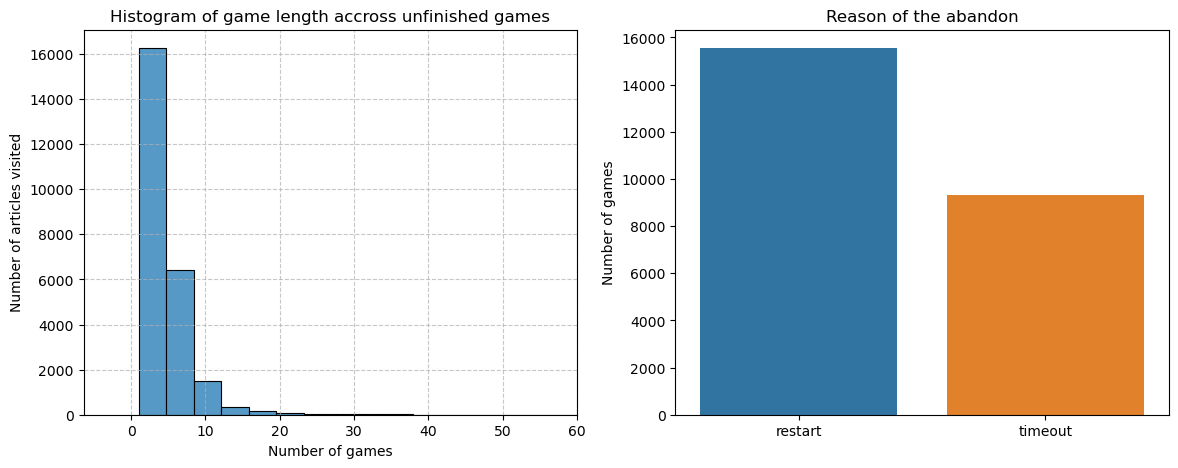

In [25]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data.paths_unfinished["paths"].apply(lambda x: len(x)), bins=40, ax = axes[0])
axes[0].set_xlim(right=60)
axes[0].set_title('Histogram of game length accross unfinished games')
axes[0].set_xlabel('Number of games')
axes[0].set_ylabel('Number of articles visited')
axes[0].grid(True, linestyle='--', alpha=0.7)

sns.barplot(x = data.paths_unfinished["rating"].value_counts().index, y = data.paths_unfinished["rating"].value_counts().values,hue = data.paths_unfinished["rating"].value_counts().index)
axes[1].set_title('Reason of the abandon')
axes[1].set_xlabel(' ')
axes[1].set_ylabel('Number of games')

plt.show()

We observe that many games stop at the very beginning, which could indicate that players either don't understand or don't feel confident that they can reach the target point, suggesting a potential lack of knowledge regarding the target or start point. Additionally, we see that most games are abandoned due to a restart, which might suggest that the game is perceived as too difficult by the players, while timeouts may indicate that players attempted the game but were unable to find a solution. 

Depending on the path taken by the players, we could analyze more deeply the reasons for abandonment — whether the game was perceived as impossible (in cases of restart from the beginning), or if players encountered a dead-end for example.

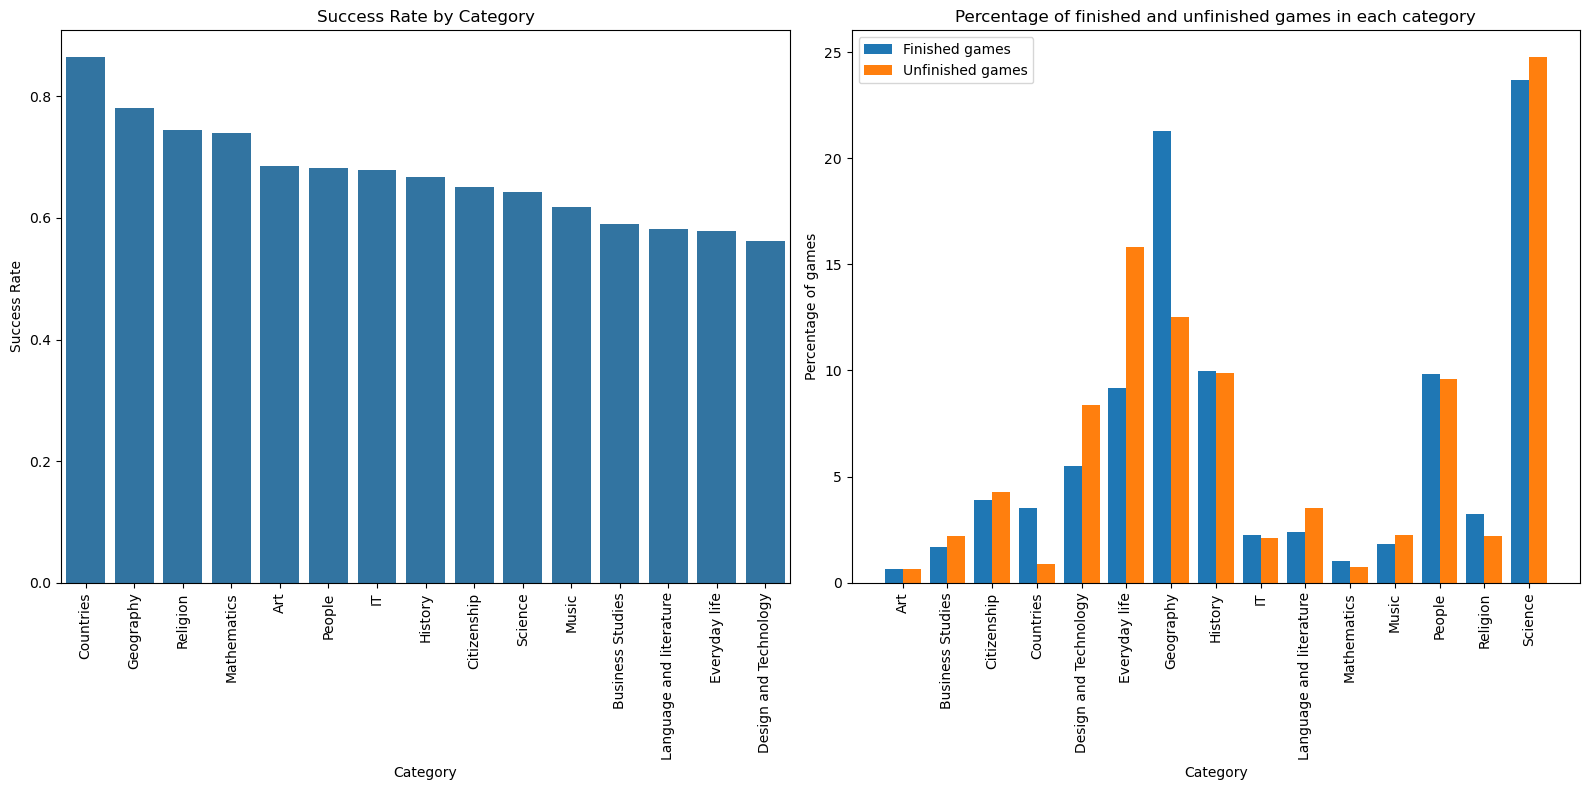

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Success Rate by Category
cat_success_rate = success_rate_category(data, games_unfinished)
sns.barplot(x=cat_success_rate.index, y=cat_success_rate, ax=axes[0])
axes[0].set_title("Success Rate by Category")
axes[0].set_xlabel("Category")
axes[0].set_ylabel("Success Rate")
axes[0].tick_params(axis='x', rotation=90)

# Percentage of finished and unfinished games
cat_finished, cat_unfinished = target_category(data, games_unfinished, games)
axes[1].bar(x=cat_finished["category"], height=cat_finished["nb_games"], width=-0.4, align='edge', label="Finished games")
axes[1].bar(x=cat_unfinished["category"], height=cat_unfinished["nb_games"], width=0.4, align='edge', label="Unfinished games")
axes[1].set_xlabel("Category")
axes[1].set_ylabel("Percentage of games")
axes[1].set_title("Percentage of finished and unfinished games in each category")
axes[1].tick_params(axis='x', rotation=90)

axes[1].legend()

plt.tight_layout()
plt.show()

These plots show that games with target articles in the "Countries" category exhibit significantly higher success rates compared to those in the "Design and Technology" category. This trend suggests that players may possess greater knowledge or familiarity with countries, resulting in higher completion rates for games in this category. It is important to note, however, that the number of games in the "Countries" category is much lower than that in other categories, such as "Geography." These two visualizations provide a clear overview of game success rates based on the target article's category, while taking into account the number of games in each category.

Additionally, we want to investigate where the games tend to stop, as this can provide valuable insights into why players abandon the game. Did they encounter a dead-end, or were they unable to identify the next step to take?

In [27]:
abandon = get_abandon_point(data)
abandon.sort_values("nb_games",ascending =False).head()

  0%|          | 0/24875 [00:00<?, ?it/s]

100%|██████████| 24875/24875 [00:25<00:00, 986.96it/s] 


,abandon_point,nb_games
66,United States,660
97,United Kingdom,299
75,England,285
801,Brain,278
233,Theatre,202


Weirdly, the most frequent stop points appear to be major hubs (e.g., US, UK...), which raises the question of why players tend to stop at these points. To clarify further, we can examine the number of clicks made by a player in an unfinished path, as well as the reason given for abandonment, whether it be a restart or a timeout.

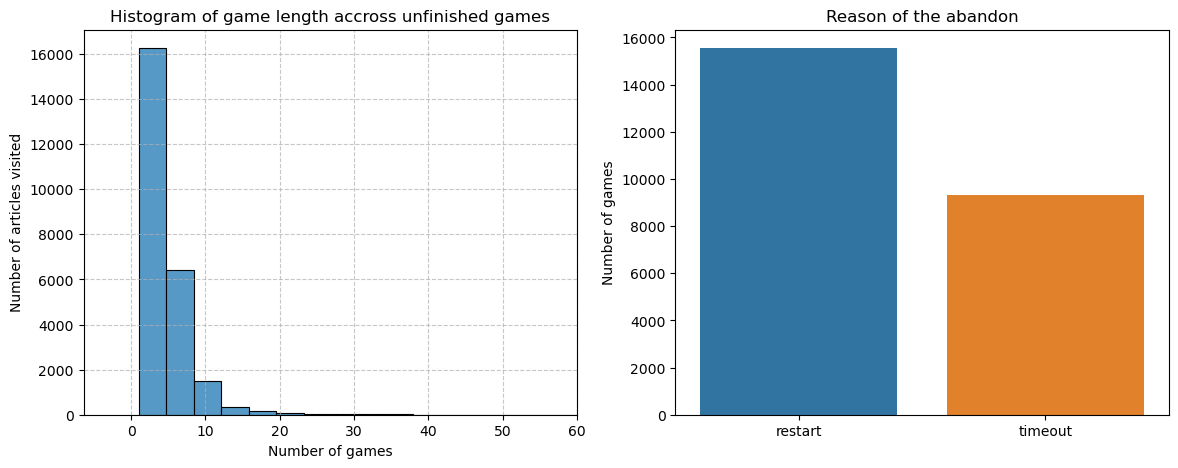

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data.paths_unfinished["paths"].apply(lambda x: len(x)), bins=40, ax = axes[0])
axes[0].set_xlim(right=60)
axes[0].set_title('Histogram of game length accross unfinished games')
axes[0].set_xlabel('Number of games')
axes[0].set_ylabel('Number of articles visited')
axes[0].grid(True, linestyle='--', alpha=0.7)

sns.barplot(x = data.paths_unfinished["rating"].value_counts().index, y = data.paths_unfinished["rating"].value_counts().values,hue = data.paths_unfinished["rating"].value_counts().index)
axes[1].set_title('Reason of the abandon')
axes[1].set_xlabel(' ')
axes[1].set_ylabel('Number of games')

plt.show()

We observe that many games stop at the very beginning, which could indicate that players either don't understand or don't feel confident that they can reach the target point, suggesting a potential lack of knowledge regarding the target or start point. Additionally, we see that most games are abandoned due to a restart, which might suggest that the game is perceived as too difficult by the players, while timeouts may indicate that players attempted the game but were unable to find a solution.

Depending on the path taken by the players, the next step would be to analyze more deeply the reasons for abandonment — whether the game was perceived as impossible (in cases of restart from the beginning), or if players encountered a dead-end for example.

## Analysis of links

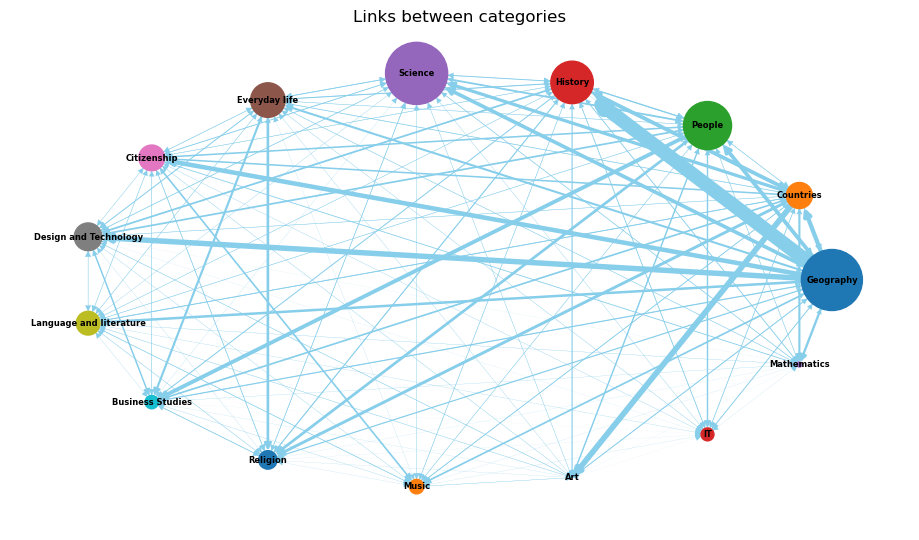

In [29]:
sum_links_data = get_grouped_category_data(data, includeGeography=True)
create_sum_graph(data, sum_links_data)

For interpretation: The plots displays the links between categories in the following way:
- The size of the nodes is determined by the number of articles in that category (MinMax-Normalised).
- The size of the edges is determined by the amount of outgoing links from one category to another, with respect to (dived by) the amount of articles there are in the outgoing article (MinMax-Normalised).

The plot shows the following:
- "Geography" has the most outgoing links to other categories with respect to its size. Hence, it indicates that many of the large hubs may coincide in this category. Further investigation is of interest. 

- "Countries" also has a lot of outgoing links to other categories with respect to its size. Not too suprising since atricles that are in "Countries" also belongs to the category "Geography". 

To see the second point more clearly, the plot below displays the same thing but with the edges from "Geogrpahy" removed. The big difference in size between edges between the plots are due to the fact that the edges in the second one have been normalised without the weights of the "Geograhpy" edges.

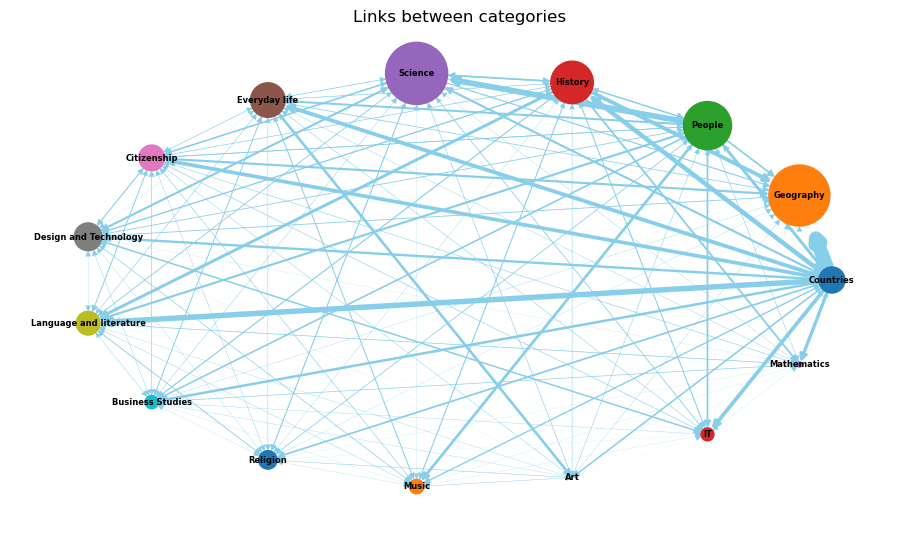

In [30]:
sum_links_data = get_grouped_category_data(data, includeGeography=False)
create_sum_graph(data, sum_links_data)

Apart from showing the second point above more clearly, this plot also shows that there seems to be a lot of links between the categories "Science" and "People" (both ways), with respect to the sizes of these categories. Nothing suprising since scientific discoveries is almost always connected to a certain person/persons.

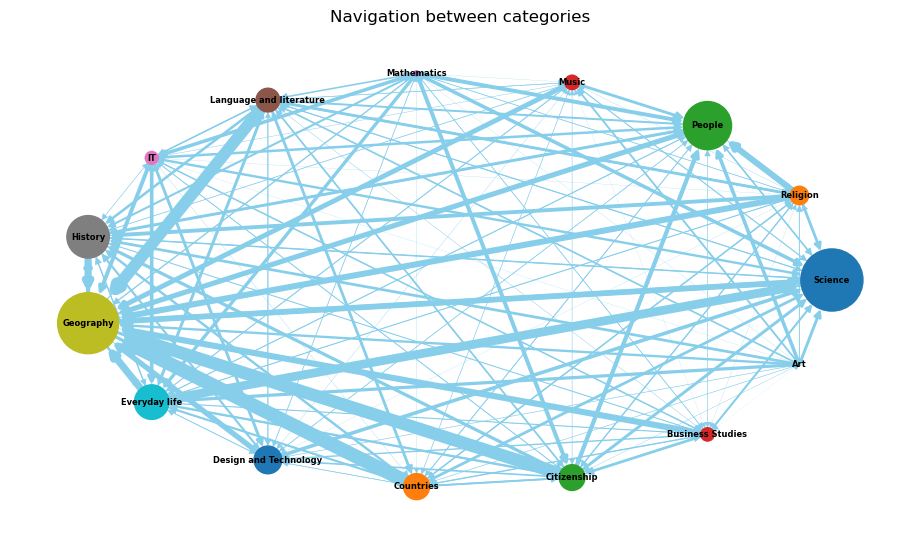

In [31]:
from src.navigation_analysis import *
sum_nav_data = get_category_navigation_matrix(data)
create_sum_graph(data, sum_nav_data, "Navigation between categories")

This plot shows the trans categorical navigation behaviour (i.e. the number of clicks navigating to another category). As could be expected people navigate most between the categories with the most amount of articles in them. It looks like "navigation highways" have been established. Despite a similar amount of articles, users navigate much more via "Geography" than science, which is likely because "Geography" is better connected to other categories as can be seen at the number of links in the previous graph. Further patterns can be analyzed from this, such as that users tend to navigate from "Business Studies" to "Countries" via "Geography" and not direcly despite the number of links.

## Analysis of the shortest paths
Now moving on to analysis of shortest paths. To do this we analysed the shortest paths between the games played in the dataset. This was done in order to save time for the computation and since these are of most interest to us as this can tell us something about the navigation of users and how well they navigate in the game.

To calculate the shortest paths the dijkstra algorithm was used.

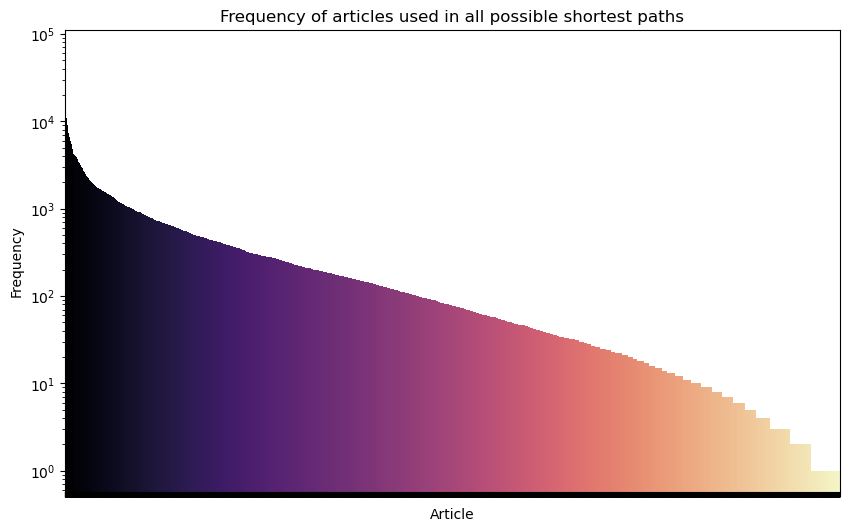

In [32]:
# Calculate shortest_path.csv if not already exists in 
csv_path = calculate_all_shortest_paths(data)

# Calculates article frequency  in all shortest paths
shortest_path_frequency = shortest_path_article_frequency(csv_path)

# Plots the frequency of articles from all shortest paths
plt.figure(figsize=(10,6))
sns.barplot(data=shortest_path_frequency,
            x ='shortest_paths',  
            y='count',
            palette='magma',
            hue='shortest_paths',
            width=1)
plt.yscale('log')
plt.gca().set_xticklabels([])
plt.xlabel("Article")
plt.ylabel("Frequency")
plt.title('Frequency of articles used in all possible shortest paths')
plt.show()

For interpretation:
This barplot displays the total amount of times an article is used in all possible shortest paths between starting and target article in all games (not counting the starting or target article).

From the results it can be seen that some articles are used significantly more often than others (the y-axis is log-scaled). Hence, this indicates that the more frequently used articles could be considered as hubs and that further investigation in this matter is of interest. To get a sense of which articles are more used, see plot below.

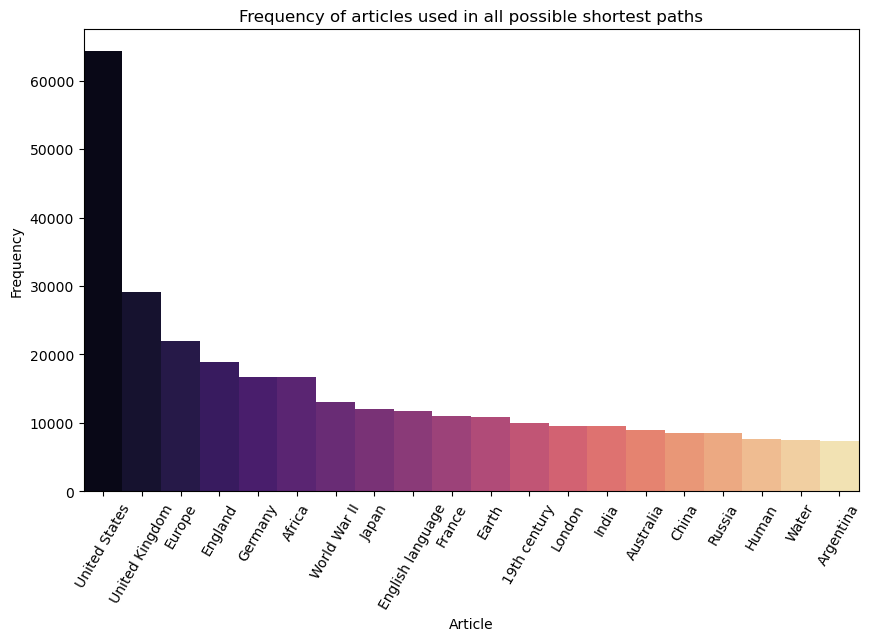

In [33]:
# Plots the frequency of articles from all shortest paths
plt.figure(figsize=(10,6))
sns.barplot(data=shortest_path_frequency.head(20),
            x ='shortest_paths',  
            y='count',
            palette='magma',
            hue='shortest_paths',
            width=1)
plt.xticks(rotation=60)
plt.xlabel("Article")
plt.ylabel("Frequency")
plt.title('Frequency of articles used in all possible shortest paths')
plt.show()

For interpretation: The 20 most used articles from the plot above (y-axis not log-scaled).

From the plot the following things can be seen: 

- "United States" is by far the most used one and hence it can be motivated as the biggest hub in the sense that, on average, going through it will lead you to your target the quickest. 

- The biggest hubs tend to be in the categories "Countries" and "Geography". Indicating that these articles may a have highly varied set of links to other articles. Something that is also shown by the plots under "Analysis of links network".

Notably is that this result is also dependent on what games players have selected to play as we only calculated the shortest path for games people played. This is something we need to analyse further. Do people select to play only certain games? What can this tell us about common knowledge?